### Imports

In [1]:
#Importing required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

### Reading of data

In [2]:
#Read the csv file
df=pd.read_csv('CarPrice_Assignment.csv')
df.shape

(205, 26)

In [3]:
#dropping Car_ID since its an unique identity and serves no other purpose
df=df.drop('car_ID',1)
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Analysis and cleaning

In [4]:
#Convert the CarNames to lower case and remove the model name
df.CarName=df.CarName.apply(lambda x:x.lower().split(' ')[0])

In [5]:
#Defining function to correct the wrong CarNames due to spelling mistake and abbrevations
def name_cor(x):
    if x =='maxda':
        return 'mazda'
    elif x=='vw' or x=='vokswagen':
        return 'volkswagen'
    else:
        return x

In [6]:
#Apply function to correct the names
df.CarName=df.CarName.apply(name_cor)

In [7]:
#Separetly identifying the numeric  variables
numeric= df.select_dtypes(include = [np.number])
numeric_list=numeric.columns.tolist()

In [8]:
#Defining Label Encoder
le=LabelEncoder()

In [9]:
#The following columns have only two unique values and henceforth produce same results in both Label Encoding and Dummy Variables
df.aspiration=le.fit_transform(df.aspiration)
df.doornumber=le.fit_transform(df.doornumber)
df.enginelocation=le.fit_transform(df.enginelocation)
df.fueltype=le.fit_transform(df.fueltype)

In [10]:
#Since Number of values in this column is very high,its better to use label encoder rather than dummy variables
df.CarName=le.fit_transform(df.CarName)

In [11]:
#Creating Dummy Variables for the remaining other Categorical Values
df=df.join(pd.get_dummies(df.fuelsystem,drop_first=1))
df=df.drop('fuelsystem',1)

df=df.join(pd.get_dummies(df.cylindernumber,drop_first=1))
df=df.drop('cylindernumber',1)

df=df.join(pd.get_dummies(df.enginetype,drop_first=1))
df=df.drop('enginetype',1)

df=df.join(pd.get_dummies(df.drivewheel,drop_first=1))
df=df.drop('drivewheel',1)

df=df.join(pd.get_dummies(df.carbody,drop_first=1))
df=df.drop('carbody',1)


In [12]:
#Shape of df after dummy variables
df.shape

(205, 45)

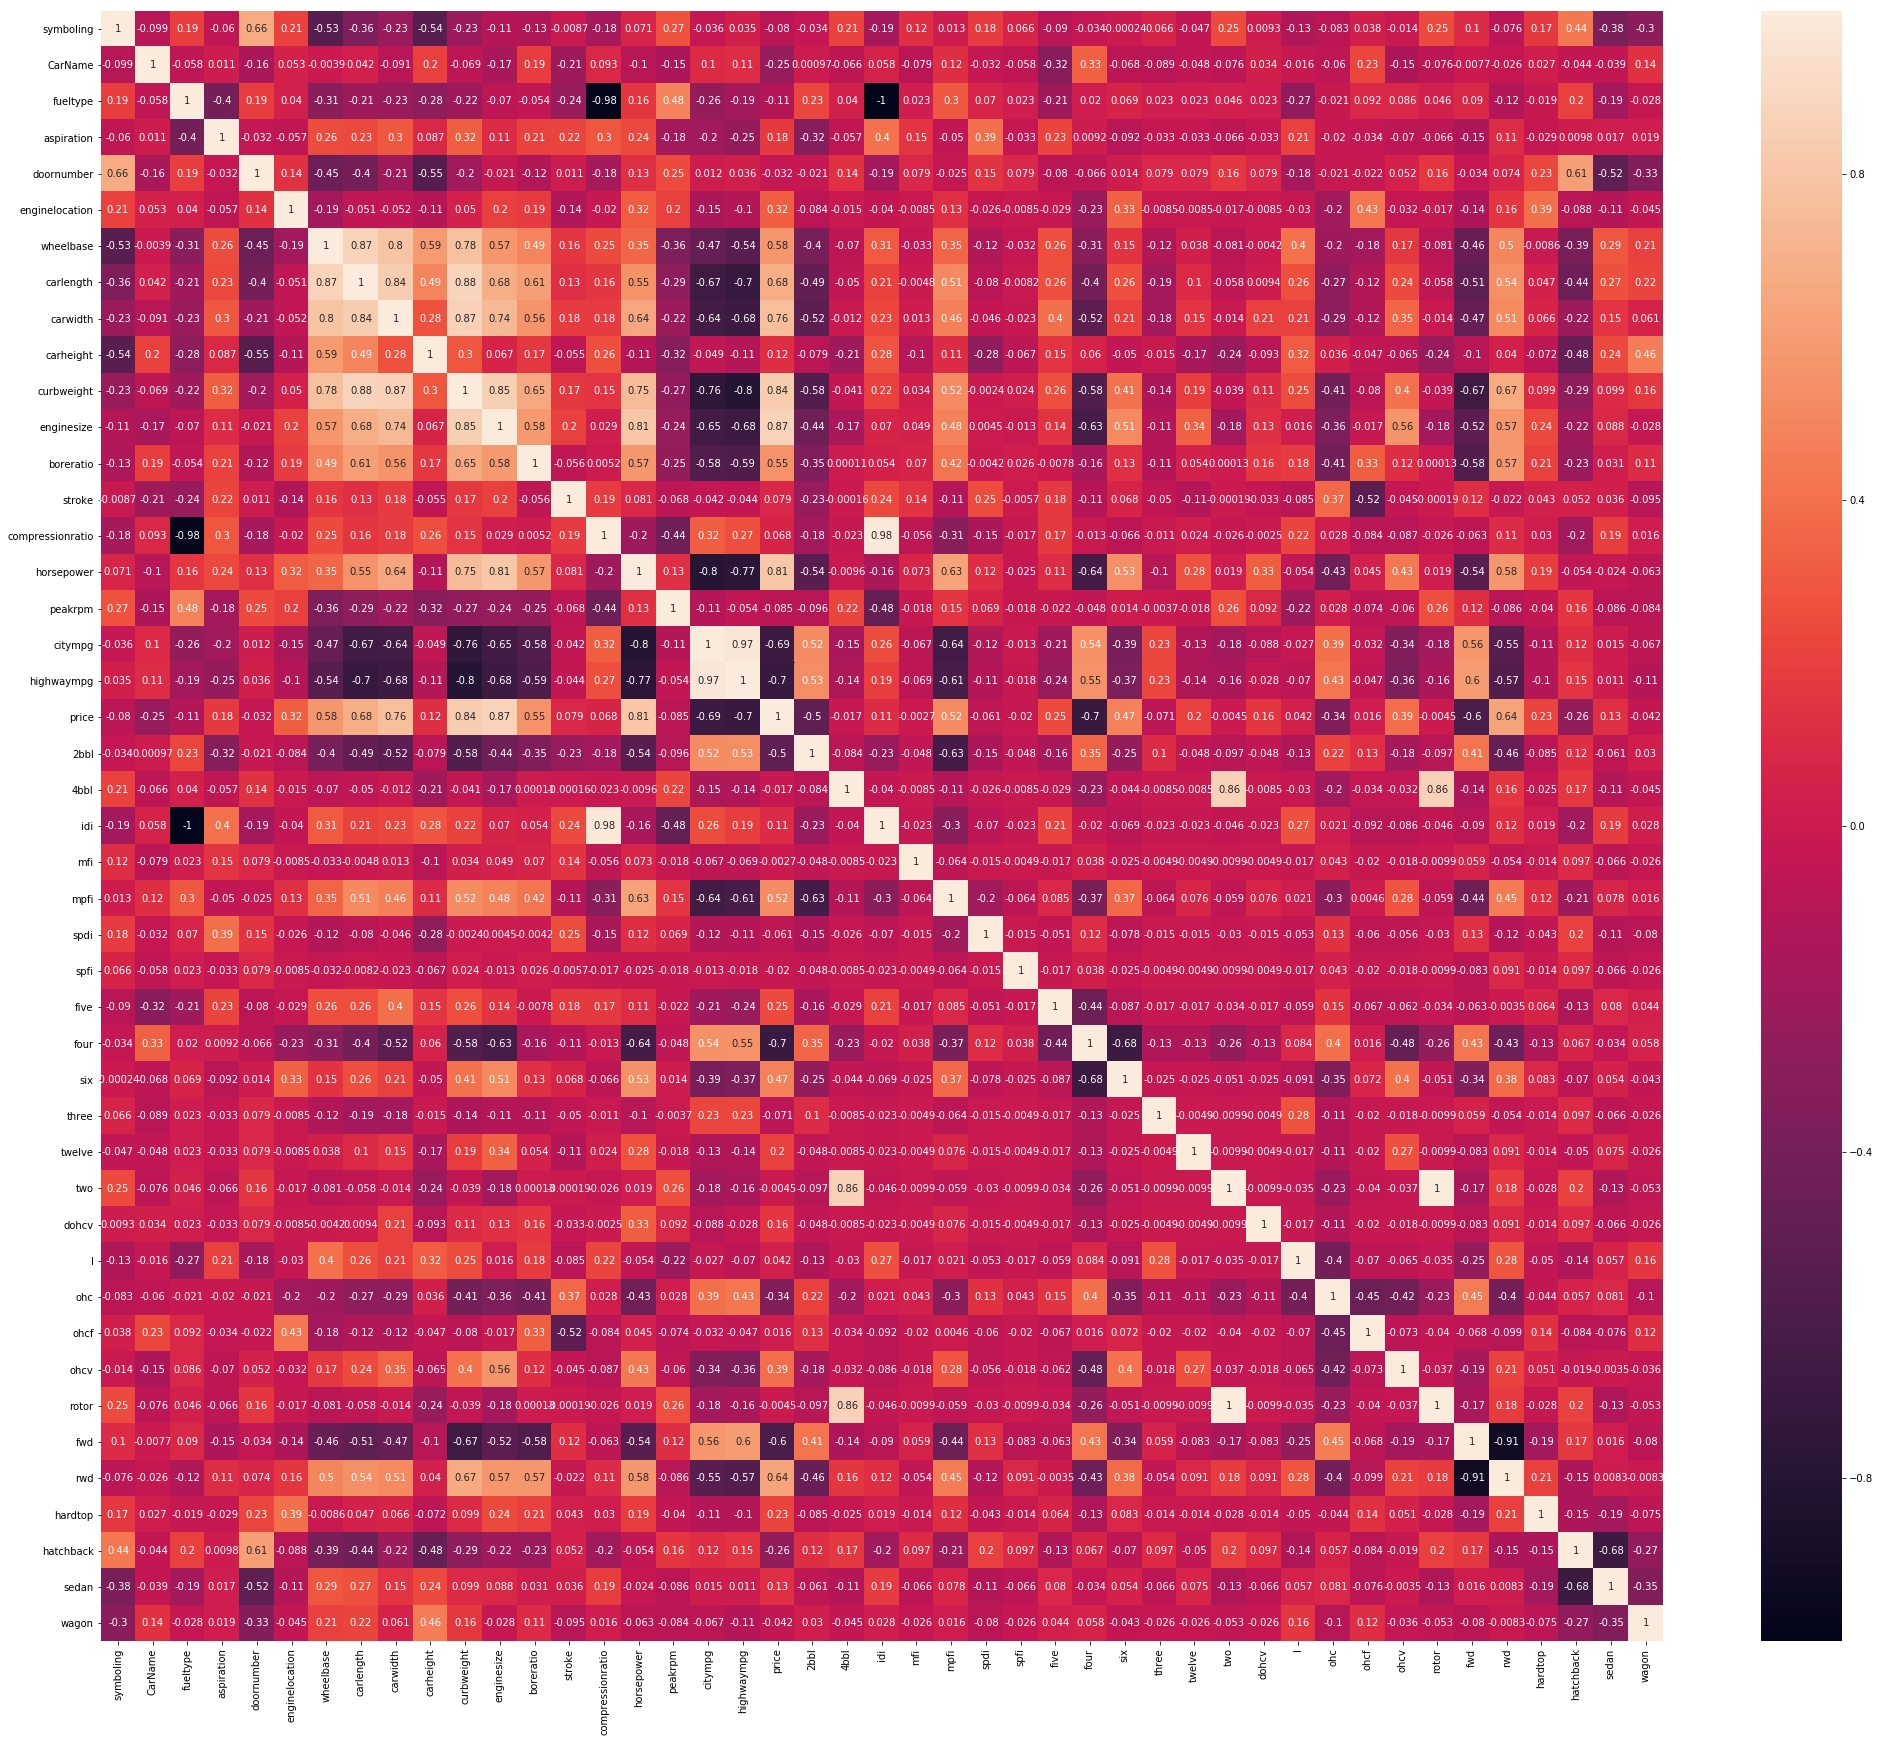

In [13]:
#Visualiztion of Correlation
plt.subplots(figsize=(35,30))
sns.heatmap(df.corr(),annot=True)

### Preparation of Data for Modelling

In [14]:
#Separating the target variable from the dataframe 
y=df.price
df=df.drop('price',1)

In [15]:
#Poping Price from numeric_list before Scaling the values
numeric_list.pop(-1)

'price'

In [16]:
#Defining MinMaxScaler
mn=MinMaxScaler()

In [17]:
#Scale the numeric values
df[numeric_list]=mn.fit_transform(df[numeric_list])

In [18]:
#Splitting the data into test and train data
X_train,X_test,y_train,y_test=train_test_split(df,y,test_size=0.3,train_size=0.7,random_state=8)

In [19]:
#Adding constant to the datasets
X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)

In [20]:
#List of the final variable selected by manual removing of variables based on VIF value and p-value
final=['const','CarName','enginelocation','carwidth','hatchback','fwd','l','six','three']

### Training of Linear Regression model

In [21]:
#Train the Linear Regression model for the selected variable and print the summary of the model
lm = sm.OLS(y_train,X_train[final]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     91.53
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.64e-50
Time:                        23:13:17   Log-Likelihood:                -1362.1
No. Observations:                 143   AIC:                             2742.
Df Residuals:                     134   BIC:                             2769.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5176.8789   1462.098      3.

In [22]:
#VIF values of the selected variables
vif = pd.DataFrame()
vif['Features'] = final
vif['VIF'] = [variance_inflation_factor(X_train[final].values, i) for i in range(X_train[final].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,26.06
3,carwidth,1.47
5,fwd,1.47
6,l,1.32
7,six,1.29
8,three,1.26
2,enginelocation,1.16
4,hatchback,1.11
1,CarName,1.09


In [23]:
y_train_pred=lm.predict(X_train[final])

D:\kilobyte\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Errors')

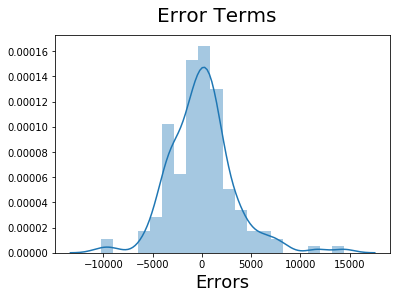

In [24]:
#Plotting the error terms distribution
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)    

### Prediction

In [25]:
#Predicting using the trained model for test_data
y_pred=lm.predict(X_test[final])

In [26]:
#Finding R-Squared value for the test dataset
r2_score(y_test,y_pred)

0.8483608215928551

## Explanations
The variable reduction is not showcased since reducing from 43 to 8 variables manually is a long and reptitive process occupying lots of space.

Only the final model is showed in the notebook.

The variables where reduced based on their VIF Value and P-value.

The predictor variables are CarName,enginelocation,carwidth,hatchback,fwd,l,six,three excluding constant.

The train-test split is 70% Training and 30% Testing.

The R_squared value of training set is 84.5% and the adjusted R_squared value is 83.6%.

The R_squared value of test set is 84.8% which is within 5% range of training set R_squared vale.
